In [25]:
import os
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from typing import List
np.set_printoptions(threshold=np.inf)  

from fragment import *
from side import *
from sides_comparison import *
from utils import *
from puzzle import *
import global_values
from displaying import *
from groups import *
from merge_groups_best_candidate import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
global_values.MODEL = SiameseCNN()
global_values.MODEL.load_state_dict(torch.load("siamese_weights.pth", map_location=device))
global_values.MODEL.to(device)
global_values.MODEL.eval()
global_values.DEVICE = device
NN_SCORING = True

global_values.IMAGE_TH = 0.1
global_values.GROUP_TH = 0.01

In [26]:
image_path = "disney_puzzle/aladin.jpg" 

output_folder = "fragments"
global_values.COL_NR = 12
global_values.ROW_NR = 12
fragments, tile_h, tile_w = divide_image(image_path, output_folder, global_values.COL_NR, global_values.ROW_NR)
global_values.TILE_H = global_values.TILE_W = max(tile_h, tile_w)



sides_comparisons = create_sides_comparisons(fragments)



sorted_sides_comparisons = sort_sides_comparisons(sides_comparisons)

n = len(fragments)
s = 4  
global_values.SYMMETRIC_COMPARISONS = [[[[None for _ in range(s)] for _ in range(s)] for _ in range(n)] for _ in range(n)]

for c in sides_comparisons:
    global_values.SYMMETRIC_COMPARISONS[c.side1.fragment_idx][c.side2.fragment_idx][c.side1.side_idx][c.side2.side_idx] = c
    symmetric_comp = SidesComparison(fragments, c.side2, c.side1)
    global_values.SYMMETRIC_COMPARISONS[c.side2.fragment_idx][c.side1.fragment_idx][c.side2.side_idx][c.side1.side_idx] = symmetric_comp



Rotations by fragment: 0)3.0, 1)2.0, 2)2.0, 3)2.0, 4)1.0, 5)2.0, 6)0.0, 7)0.0, 8)1.0, 9)3.0, 10)3.0, 11)2.0, 12)2.0, 13)3.0, 14)1.0, 15)0.0, 16)1.0, 17)1.0, 18)1.0, 19)1.0, 20)2.0, 21)0.0, 22)0.0, 23)2.0, 24)3.0, 25)0.0, 26)3.0, 27)1.0, 28)3.0, 29)2.0, 30)0.0, 31)3.0, 32)2.0, 33)0.0, 34)2.0, 35)0.0, 36)3.0, 37)2.0, 38)0.0, 39)3.0, 40)1.0, 41)0.0, 42)1.0, 43)1.0, 44)2.0, 45)0.0, 46)2.0, 47)0.0, 48)2.0, 49)1.0, 50)1.0, 51)2.0, 52)2.0, 53)2.0, 54)2.0, 55)1.0, 56)2.0, 57)0.0, 58)2.0, 59)2.0, 60)0.0, 61)0.0, 62)2.0, 63)0.0, 64)3.0, 65)2.0, 66)3.0, 67)0.0, 68)1.0, 69)2.0, 70)2.0, 71)0.0, 72)3.0, 73)0.0, 74)1.0, 75)3.0, 76)3.0, 77)3.0, 78)1.0, 79)1.0, 80)2.0, 81)1.0, 82)0.0, 83)1.0, 84)0.0, 85)2.0, 86)2.0, 87)2.0, 88)0.0, 89)1.0, 90)3.0, 91)0.0, 92)2.0, 93)2.0, 94)3.0, 95)3.0, 96)0.0, 97)0.0, 98)1.0, 99)1.0, 100)2.0, 101)1.0, 102)2.0, 103)0.0, 104)3.0, 105)3.0, 106)3.0, 107)1.0, 108)3.0, 109)3.0, 110)0.0, 111)3.0, 112)1.0, 113)1.0, 114)3.0, 115)2.0, 116)1.0, 117)2.0, 118)0.0, 119)3.0, 120)0.0

100%|██████████| 143/143 [21:53<00:00,  9.19s/it]


In [27]:
# for c in sorted_sides_comparisons:
#     print(c.score)
#     nr_of_fr1_rotations = (4 + 1 - c.side1.side_idx) % 4
#     nr_of_fr2_rotations = (4 + 3 - c.side2.side_idx) % 4

#     fr1_img = rotate_image(fragments[c.side1.fragment_idx].value, nr_of_fr1_rotations)
#     fr2_img = rotate_image(fragments[c.side2.fragment_idx].value, nr_of_fr2_rotations)

#     print(f"comparing side {c.side1.side_idx} and side {c.side2.side_idx}")
#     plt.figure(figsize=(10, 5))
#     plt.subplot(1, 2, 1)
#     plt.imshow(fr1_img)
#     plt.axis('off')

#     plt.subplot(1, 2, 2)
#     plt.imshow(fr2_img)
#     plt.axis('off')
#     plt.show()


In [28]:
groups = []
fragment_idx_to_group_idx = [None for _ in fragments]

for fr_idx in range(len(fragments)):
    new_group = Group(fr_idx)
    groups.append(new_group)
    fragment_idx_to_group_idx[fr_idx] = fr_idx
# show_all_groups(groups, fragments)
print(fragment_idx_to_group_idx)



[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143]


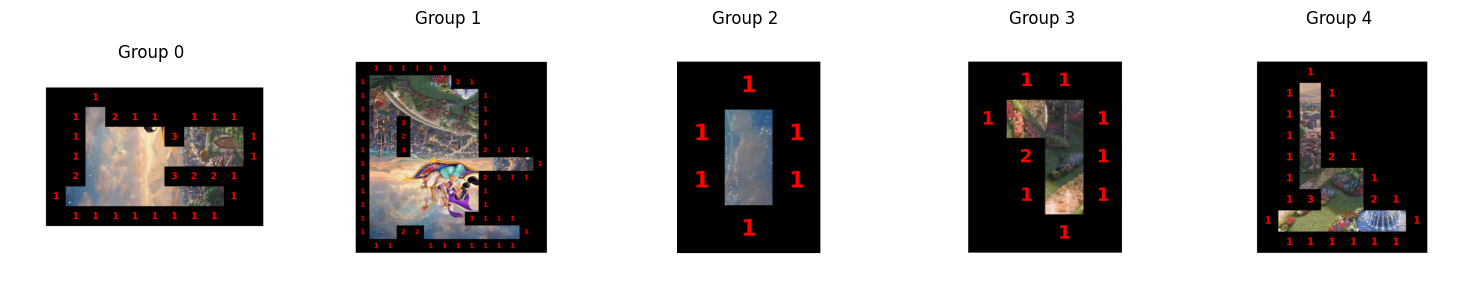

In [29]:
for comp in sorted_sides_comparisons:
    if comp.score <= global_values.IMAGE_TH:

        anchor_fragment_idx = comp.side1.fragment_idx
        pasted_fragment_idx = comp.side2.fragment_idx
        anchor_group_idx = fragment_idx_to_group_idx[anchor_fragment_idx]
        pasted_group_idx = fragment_idx_to_group_idx[pasted_fragment_idx]

        if anchor_group_idx != pasted_group_idx:

            shifted_anchor_group, shifted_pasted_group, pasted_group_additional_rotation = simulate_merge_positions(fragments, comp, groups[anchor_group_idx], groups[pasted_group_idx])

            if does_merge_fit_within_bounds(shifted_anchor_group):
                if check_groups_shapes_for_merging(shifted_anchor_group, shifted_pasted_group):
                    # print(f"{comp}")

                    if check_all_group_matchings_scores(fragments, pasted_group_additional_rotation, shifted_anchor_group, shifted_pasted_group):    
                        # score = calculate_all_group_matchings_scores(shifted_anchor_group, shifted_pasted_group)
                        # anchor_img = shifted_anchor_group.show_group(fragments,0)
                        # pasted_img = shifted_pasted_group.show_group(fragments,pasted_group_additional_rotation)
                        # plt.imshow(anchor_img)
                        # plt.show()
                        # plt.imshow(pasted_img)
                        # plt.show()
                        # print("-------------------------------------------")
                        groups[anchor_group_idx] = merge_groups(fragments, pasted_group_additional_rotation, shifted_anchor_group, shifted_pasted_group, fragment_idx_to_group_idx)
                        update_after_merge(groups, fragments, fragment_idx_to_group_idx, pasted_group_idx)
show_all_groups(groups, fragments, fragment_idx_to_group_idx, 0)

# for g in groups:
#     print(g.fragment_positions)


Merged group 0 and 4 with total score: 0.01153987567522563 using: Sides Comp: Score=0.0006262317765504122 Fragment_idx1=62, Side_idx1=1; fragment_idx2=61, side_idx2=1
Merged group 0 and 3 with total score: 0.9724534034729004 using: Sides Comp: Score=1.0 Fragment_idx1=75, Side_idx1=3; fragment_idx2=121, side_idx2=3
Merged group 1 and 2 with total score: 0.9994406223297119 using: Sides Comp: Score=1.0 Fragment_idx1=80, Side_idx1=3; fragment_idx2=8, side_idx2=3
No valid merge candidates found.


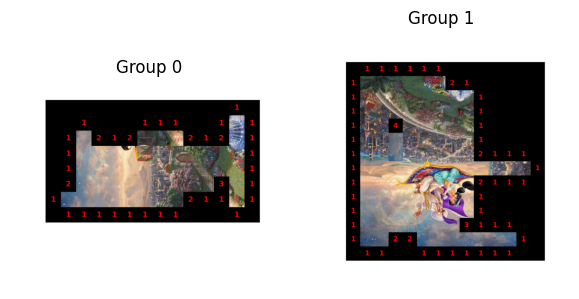

In [30]:
groups, fragments, fragment_idx_to_group_idx = solve_groups_safe(groups, fragments, fragment_idx_to_group_idx)
show_all_groups(groups, fragments, fragment_idx_to_group_idx, 0)



In [31]:
gt_comparisons = read_valid_comparisons(os.path.join("solution","valid_comparisons.txt"))



comparisons = []

for g in groups:
    n = len(g.grid)
    m = len(g.grid[0])

    for i in range(n):
        for j in range(m):
            fr1_idx = g.grid[i][j]
            if fr1_idx is not None:
                if j + 1 < m:
                    side1_idx = find_side_idx_of_orientation(fragments[fr1_idx].rotation, 1)
                    fr2_idx = g.grid[i][j + 1]
                    if fr2_idx is not None:
                        side2_idx = find_side_idx_of_orientation(fragments[fr2_idx].rotation,3)
                        comparisons.append((fr1_idx, fr2_idx, side1_idx, side2_idx))

                if i + 1 < n:
                    side1_idx = find_side_idx_of_orientation(fragments[fr1_idx].rotation, 2)
                    fr2_idx = g.grid[i + 1][j]
                    if fr2_idx is not None:
                        side2_idx = find_side_idx_of_orientation(fragments[fr2_idx].rotation, 0)
                        comparisons.append((fr1_idx, fr2_idx, side1_idx, side2_idx))

correct = 0
nr_of_comp = int((2 * 4 + 3 * ((global_values.COL_NR - 2) * 2 + (global_values.ROW_NR - 2)* 2) + 4 * ((global_values.COL_NR -2) * (global_values.COL_NR-2)))/2)
for s_comp in comparisons:
    for gt_comp in gt_comparisons:
        if s_comp == gt_comp:
            correct+=1
        if s_comp[0] == gt_comp[1] and s_comp[1] == gt_comp[0] and s_comp[2] == gt_comp[3] and s_comp[3] == gt_comp[2]:
            correct+=1

accuracy = (correct/nr_of_comp) * 100
print(f"Accuracy of algorithm: {accuracy}%")

Accuracy of algorithm: 39.77272727272727%


In [32]:
# introducere problema imagini input output

# care e algolritmul (greedy)
# functia de potrivire
# siameza

# cum merge pe low level, simaza pe diferiti nr pixeli
# timp

# 9 iunie licenta
